In [2]:
#!pip install bayesian-optimization

In [1]:
import sys
sys.path.append('..')
from src.models.pipeline import pipeline
import glob
import json
import os
import pandas as pd
import ast
from datetime import datetime

In [2]:
groundbase_dir = '../data/raw/groundbase'
transcripts_dir = os.path.join(groundbase_dir,'transcripts')
topic_dataset_path = os.path.join(groundbase_dir,'dataset.csv')
transcript_filespath = glob.glob(groundbase_dir + '/transcripts/*.json')

In [3]:
'''Read the transcript'''
transcripts_jsons = {}
for fl in transcript_filespath:
    with open(fl,encoding="utf8") as f:
        transcript =ast.literal_eval(f.read()) #json.load(f)
        vid = fl.split('\\')[-1].split('.')[0]
        #print(vid)
        transcripts_jsons[vid] = transcript

In [4]:
'''Read the videos metadata to perform on them the segmentation'''
df_videos = pd.read_csv(topic_dataset_path)

In [5]:


''' Transfer topic shifts time to seconds units instead HH:MM:SS'''

def topic_shifts_seconds(topic_shifts):
    tp_shift_sec=[]
    for tp in topic_shifts:
        intervals = tp.split(':')
        seconds = int(intervals[2])
        minutes = int(intervals[1]) * 60
        hours = int(intervals[0]) * 60 *60
        tp_shift_sec.append(seconds + minutes + hours)
    return tp_shift_sec


for video_id in transcripts_jsons.keys():    
    df_videos.at[df_videos['video id'] == video_id,'topic shifts(ends)'] =\
    topic_shifts_seconds(\
                         df_videos[df_videos['video id'] == \
                                   video_id]['topic shifts(ends)'])


In [22]:
df_videos

,shift index,topic shifts(ends),label,video,subject,youtube link,length,video id
0,0,677,"Syllabus , Textbook and references",Mod-01 Lec-01 Foundation of Scientific Computi...,Foundation of Scientific Computing,https://www.youtube.com/watch?v=MkiUBJcgdUY,01:05:06,MkiUBJcgdUY
1,1,765,course grading,Mod-01 Lec-01 Foundation of Scientific Computi...,Foundation of Scientific Computing,https://www.youtube.com/watch?v=MkiUBJcgdUY,01:05:06,MkiUBJcgdUY
2,2,1257,relationship between computing and science,Mod-01 Lec-01 Foundation of Scientific Computi...,Foundation of Scientific Computing,https://www.youtube.com/watch?v=MkiUBJcgdUY,01:05:06,MkiUBJcgdUY
3,3,1357,implemntation,Mod-01 Lec-01 Foundation of Scientific Computi...,Foundation of Scientific Computing,https://www.youtube.com/watch?v=MkiUBJcgdUY,01:05:06,MkiUBJcgdUY
4,4,1485,scientific computing uses,Mod-01 Lec-01 Foundation of Scientific Computi...,Foundation of Scientific Computing,https://www.youtube.com/watch?v=MkiUBJcgdUY,01:05:06,MkiUBJcgdUY
...,...,...,...,...,...,...,...,...
93,14,2947,NaN,Overview on Modern Cryptography,Cryptography and Network Security,https://www.youtube.com/watch?v=B-Xe7_mf2CY&fe...,00:58:22,B-Xe7_mf2CY
94,15,3072,NaN,Overview on Modern Cryptography,Cryptography and Network Security,https://www.youtube.com/watch?v=B-Xe7_mf2CY&fe...,00:58:22,B-Xe7_mf2CY
95,16,3276,NaN,Overview on Modern Cryptography,Cryptography and Network Security,https://www.youtube.com/watch?v=B-Xe7_mf2CY&fe...,00:58:22,B-Xe7_mf2CY
96,17,3423,NaN,Overview on Modern Cryptography,Cryptography and Network Security,https://www.youtube.com/watch?v=B-Xe7_mf2CY&fe...,00:58:22,B-Xe7_mf2CY


In [6]:
'''Global variables'''
df = pd.DataFrame()
vid = '2mC1uqwEmWQ'
video_metadata = df_videos.loc[df_videos['video id'] == vid]
ground_base = video_metadata['topic shifts(ends)'].values.tolist()[:-1]
n_clusters = len(ground_base) 
video_len = video_metadata['length'].values.tolist()[0]
curr_transcripts = transcripts_jsons[vid]    

In [7]:
def function_to_be_optimized(window_size,step_size,sim_thresh):
    window_size = int(window_size)
    step_size = int(step_size)
    df_resulsts = pipeline.run(df,ground_base,vid,video_len,curr_transcripts,\
                 window_size=window_size,step_size=step_size,n_clusters=n_clusters,
                sim_thresh=sim_thresh,sim_filter=['median',(2,2)])
    print(df_resulsts['PRECISION'].values.tolist()[0])
    return df_resulsts['PRECISION'].values.tolist()[0]

In [8]:
from bayes_opt import BayesianOptimization


In [46]:
optimizer = BayesianOptimization(
    f=function_to_be_optimized,
    pbounds={'step_size':(10,60),'window_size':(20,200),'sim_thresh':(0,1)},
    verbose=2,
    random_state=1
)

|   iter    |  target   | sim_th... | step_size | window... |
-------------------------------------------------------------
                 0
count  3969.000000
mean      0.402950
std       0.264158
min       0.000000
25%       0.223191
50%       0.284691
75%       0.590177
max       1.000000


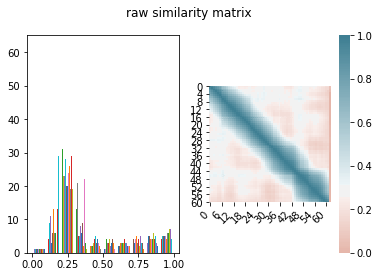

                 0
count  3969.000000
mean      0.379736
std       0.289866
min       0.000000
25%       0.223191
50%       0.284691
75%       0.590177
max       1.000000


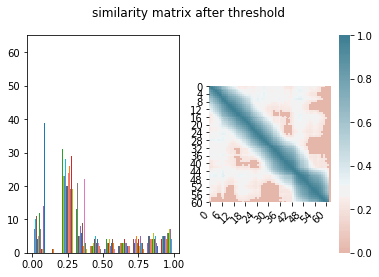

                 0
count  3969.000000
mean      0.397847
std       0.284728
min       0.000000
25%       0.236909
50%       0.292474
75%       0.603617
max       1.000000


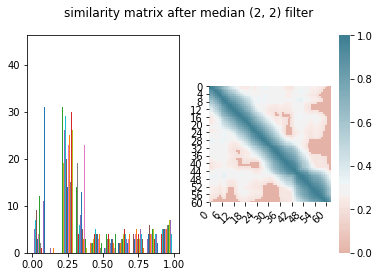

label 1 has done already cannot evaluate unsequentional segmentation, try other parameters
0.0
|  22       |  0.0      |  0.1987   |  10.08    |  140.4    |
                 0
count  5625.000000
mean      0.107353
std       0.158076
min       0.000000
25%       0.022384
50%       0.063753
75%       0.127814
max       1.000000


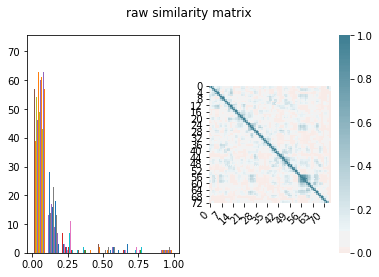

                 0
count  5625.000000
mean      0.011556
std       0.106883
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


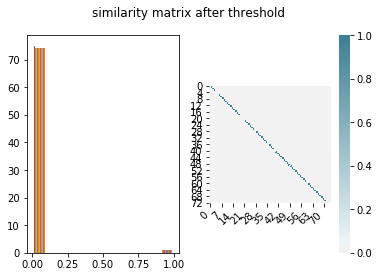

                 0
count  5625.000000
mean      0.010667
std       0.102736
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


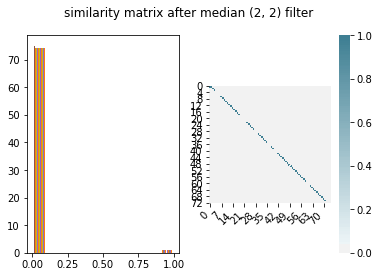

C:\Users\yaniv\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


label 6 has done already cannot evaluate unsequentional segmentation, try other parameters
0.0
|  23       |  0.0      |  1.0      |  10.0     |  20.0     |
                 0
count  4356.000000
mean      0.339811
std       0.255295
min       0.000000
25%       0.174563
50%       0.243901
75%       0.424767
max       1.000000


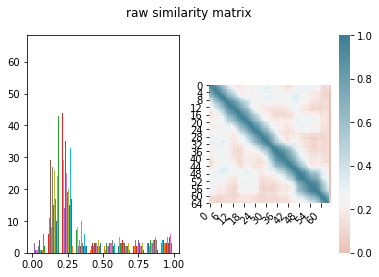

                 0
count  4356.000000
mean      0.011708
std       0.107581
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


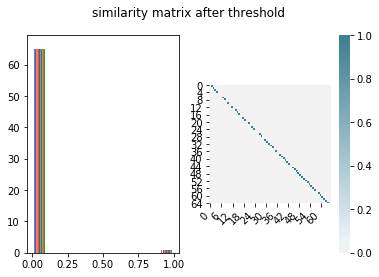

                 0
count  4356.000000
mean      0.009183
std       0.095397
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


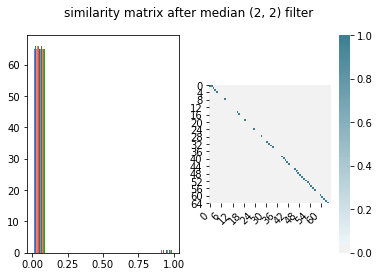

C:\Users\yaniv\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


label 1 has done already cannot evaluate unsequentional segmentation, try other parameters
0.0
|  24       |  0.0      |  1.0      |  10.0     |  111.9    |
                0
count  169.000000
mean     0.250058
std      0.244091
min      0.028452
25%      0.114319
50%      0.174196
75%      0.271770
max      1.000000


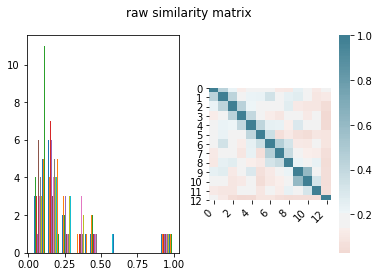

                0
count  169.000000
mean     0.250058
std      0.244091
min      0.028452
25%      0.114319
50%      0.174196
75%      0.271770
max      1.000000


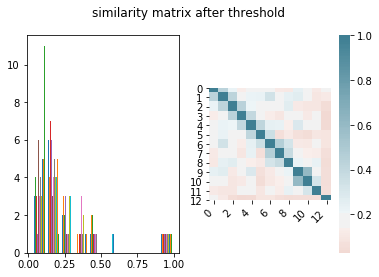

                0
count  169.000000
mean     0.292292
std      0.247398
min      0.093974
25%      0.161671
50%      0.197061
75%      0.320375
max      1.000000


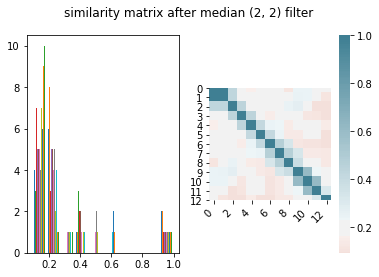

C:\Users\yaniv\Anaconda3\lib\site-packages\scipy\sparse\linalg\eigen\arpack\arpack.py:1572: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  RuntimeWarning)


TP: 6 , FP: 8, FN: 6
precision rate : 0.42857142857142855, recall rate : 0.5 
0.42857142857142855
|  25       |  0.4286   |  0.0      |  60.0     |  76.01    |
                0
count  256.000000
mean     0.429496
std      0.276774
min      0.042475
25%      0.263313
50%      0.314184
75%      0.621890
max      1.000000


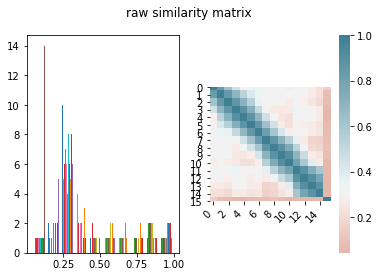

                0
count  256.000000
mean     0.050781
std      0.219981
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


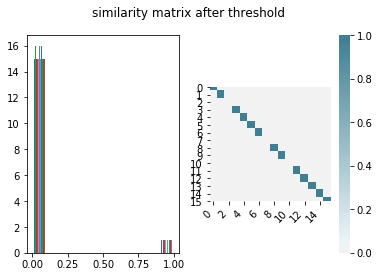

                0
count  256.000000
mean     0.046875
std      0.211785
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


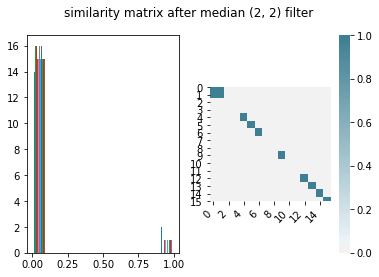

C:\Users\yaniv\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


label 2 has done already cannot evaluate unsequentional segmentation, try other parameters
0.0
|  26       |  0.0      |  1.0      |  40.52    |  164.3    |
                 0
count  5184.000000
mean      0.193029
std       0.206339
min       0.000000
25%       0.078707
50%       0.127714
75%       0.204099
max       1.000000


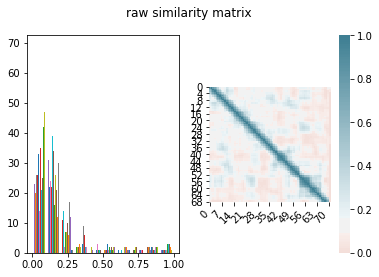

                 0
count  5184.000000
mean      0.012346
std       0.110434
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


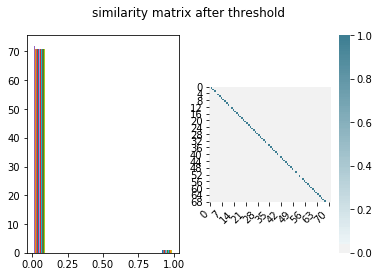

                 0
count  5184.000000
mean      0.010802
std       0.103382
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


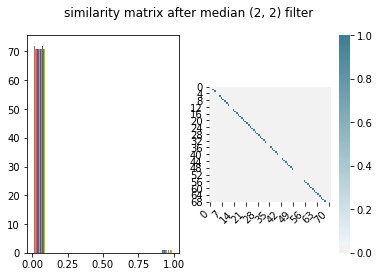

C:\Users\yaniv\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


label 2 has done already cannot evaluate unsequentional segmentation, try other parameters
0.0
|  27       |  0.0      |  1.0      |  10.0     |  49.62    |
                0
count  441.000000
mean     0.155248
std      0.207046
min      0.000000
25%      0.050462
50%      0.099947
75%      0.169069
max      1.000000


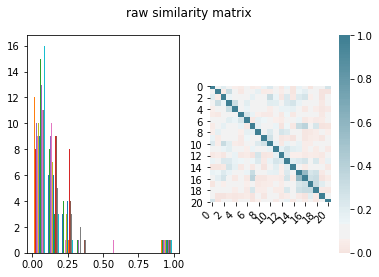

                0
count  441.000000
mean     0.047619
std      0.213201
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


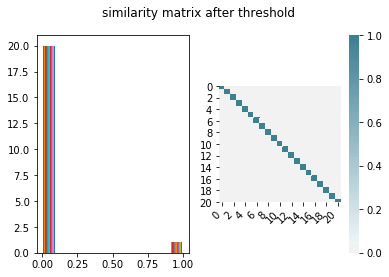

                0
count  441.000000
mean     0.052154
std      0.222590
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000


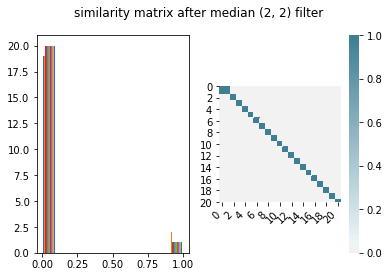

C:\Users\yaniv\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


label 2 has done already cannot evaluate unsequentional segmentation, try other parameters
0.0
|  28       |  0.0      |  0.8445   |  36.02    |  34.13    |


In [54]:
optimizer.maximize(
    init_points = 0,
    n_iter=7
)

In [55]:
for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))
print("The max is %s " %(optimizer.max))

Iteration 0: 
	{'target': 0.0, 'params': {'sim_thresh': 0.417022004702574, 'step_size': 46.0162246721079, 'window_size': 20.02058746712208}}
Iteration 1: 
	{'target': 0.35714285714285715, 'params': {'sim_thresh': 0.30233257263183977, 'step_size': 17.337794540855654, 'window_size': 36.62094705838361}}
Iteration 2: 
	{'target': 0.5, 'params': {'sim_thresh': 0.0, 'step_size': 10.0, 'window_size': 200.0}}
Iteration 3: 
	{'target': 0.0, 'params': {'sim_thresh': 0.24412228188536877, 'step_size': 11.688985890591916, 'window_size': 198.61143622842334}}
Iteration 4: 
	{'target': 0.42857142857142855, 'params': {'sim_thresh': 0.1862602113776709, 'step_size': 27.278036352152387, 'window_size': 91.41814536152059}}
Iteration 5: 
	{'target': 0.0, 'params': {'sim_thresh': 0.538816734003357, 'step_size': 30.95972572016474, 'window_size': 143.33951007141673}}
Iteration 6: 
	{'target': 0.35714285714285715, 'params': {'sim_thresh': 0.20445224973151743, 'step_size': 53.90587181954727, 'window_size': 24.929

In [68]:
optimizer_MkiUBJcgdUY = BayesianOptimization(
    f=function_to_be_optimized,
    pbounds={'step_size':(10,100),'window_size':(20,400),'sim_thresh':(0,1)},
    verbose=2,
    random_state=1
)



In [71]:
optimizer_MkiUBJcgdUY.set_bounds(new_bounds={'step_size':(10,60),'window_size':(20,200),'sim_thresh':(0,1)})

|   iter    |  target   | sim_th... | step_size | window... |
-------------------------------------------------------------
                 0
count  3025.000000
mean      0.056936
std       0.135452
min       0.000000
25%       0.010583
50%       0.028817
75%       0.057491
max       1.000000


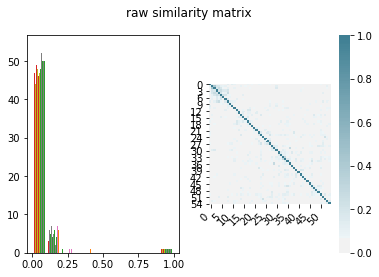

                 0
count  3025.000000
mean      0.020253
std       0.135466
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


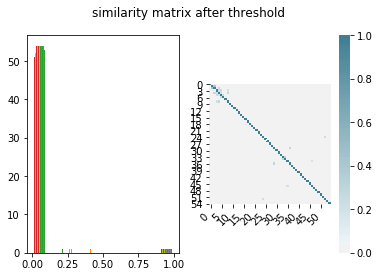

                 0
count  3025.000000
mean      0.021091
std       0.138169
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


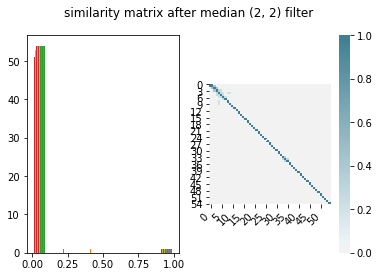

C:\Users\yaniv\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


label 4 has done already cannot evaluate unsequentional segmentation, try other parameters
0.0
|  15       |  0.0      |  0.2045   |  53.91    |  24.93    |
                 0
count  8649.000000
mean      0.132426
std       0.172089
min       0.000000
25%       0.055958
50%       0.084497
75%       0.122695
max       1.000000


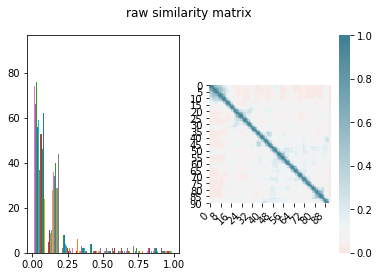

                 0
count  8649.000000
mean      0.031554
std       0.162924
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


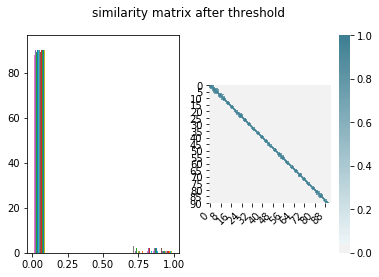

                 0
count  8649.000000
mean      0.033725
std       0.168597
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


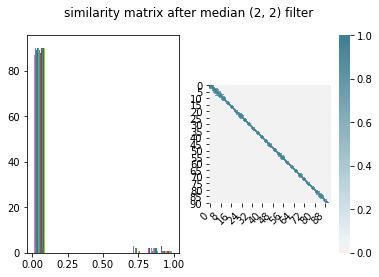

TP: 3 , FP: 15, FN: 14
precision rate : 0.16666666666666666, recall rate : 0.17647058823529413 
0.16666666666666666
|  16       |  0.1667   |  0.6705   |  30.87    |  120.6    |
                  0
count  20449.000000
mean       0.164850
std        0.193589
min        0.001613
25%        0.071589
50%        0.105798
75%        0.151453
max        1.000000


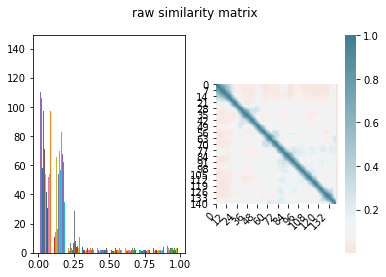

                  0
count  20449.000000
mean       0.106152
std        0.218494
min        0.000000
25%        0.000000
50%        0.000000
75%        0.151453
max        1.000000


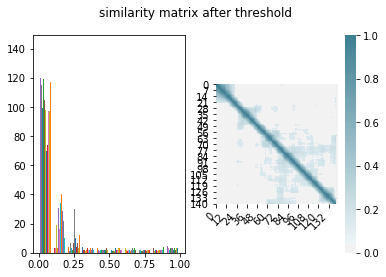

                  0
count  20449.000000
mean       0.112725
std        0.222237
min        0.000000
25%        0.000000
50%        0.000000
75%        0.156845
max        1.000000


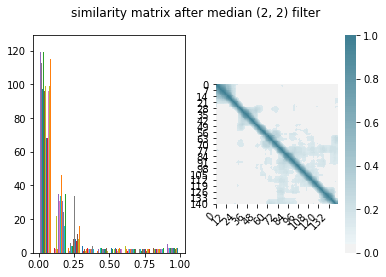

TP: 2 , FP: 16, FN: 15
precision rate : 0.1111111111111111, recall rate : 0.11764705882352941 
0.1111111111111111
|  17       |  0.1111   |  0.1404   |  19.91    |  164.1    |
                  0
count  12100.000000
mean       0.150300
std        0.184405
min        0.001760
25%        0.064878
50%        0.096342
75%        0.137094
max        1.000000


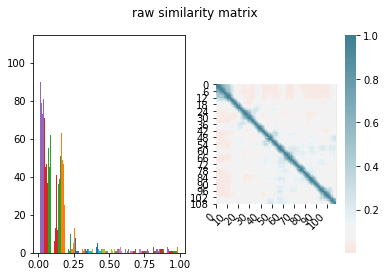

                  0
count  12100.000000
mean       0.009091
std        0.094916
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000


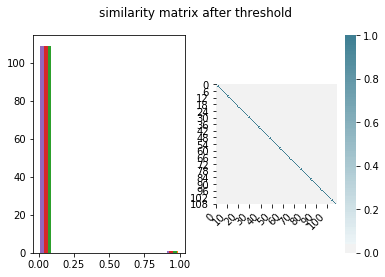

                  0
count  12100.000000
mean       0.009256
std        0.095767
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000


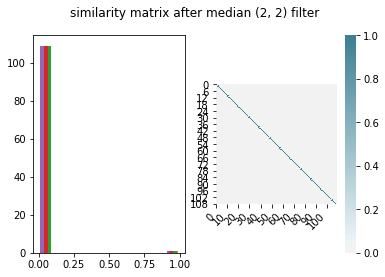

C:\Users\yaniv\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


label 8 has done already cannot evaluate unsequentional segmentation, try other parameters
0.0
|  18       |  0.0      |  0.9683   |  25.67    |  144.6    |
                  0
count  81225.000000
mean       0.039341
std        0.086158
min        0.000000
25%        0.000000
50%        0.017722
75%        0.046972
max        1.000000


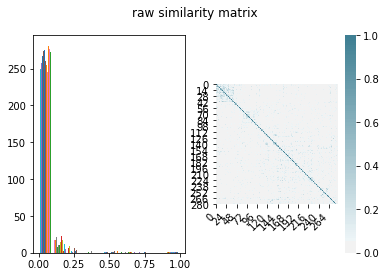

                  0
count  81225.000000
mean       0.003139
std        0.055943
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000


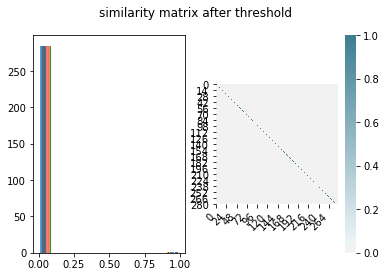

                  0
count  81225.000000
mean       0.002844
std        0.053253
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000


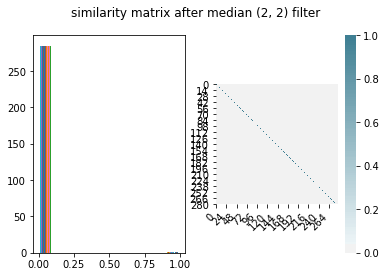

C:\Users\yaniv\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


label 7 has done already cannot evaluate unsequentional segmentation, try other parameters
0.0
|  19       |  0.0      |  1.0      |  10.0     |  20.0     |
                 0
count  2304.000000
mean      0.106117
std       0.156368
min       0.000000
25%       0.040787
50%       0.064008
75%       0.102365
max       1.000000


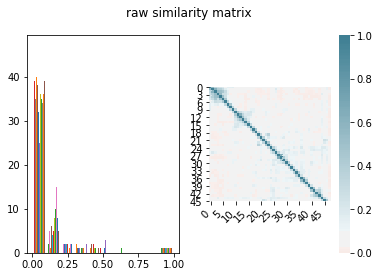

                 0
count  2304.000000
mean      0.016493
std       0.127389
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


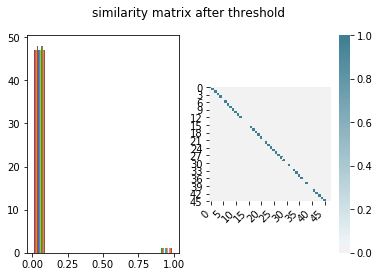

                 0
count  2304.000000
mean      0.014323
std       0.118844
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


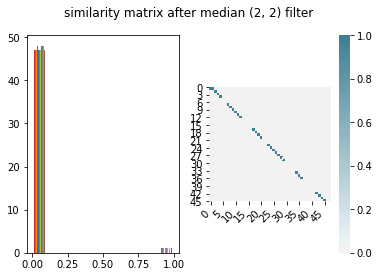

C:\Users\yaniv\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


label 2 has done already cannot evaluate unsequentional segmentation, try other parameters
0.0
|  20       |  0.0      |  1.0      |  60.0     |  82.79    |
                 0
count  2209.000000
mean      0.144404
std       0.182114
min       0.007831
25%       0.062020
50%       0.092213
75%       0.135115
max       1.000000


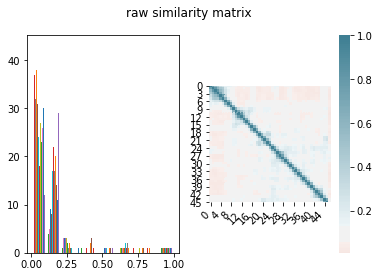

                 0
count  2209.000000
mean      0.016297
std       0.126644
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


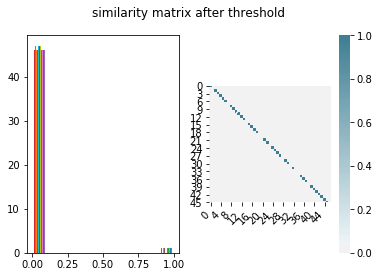

                 0
count  2209.000000
mean      0.013128
std       0.113849
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


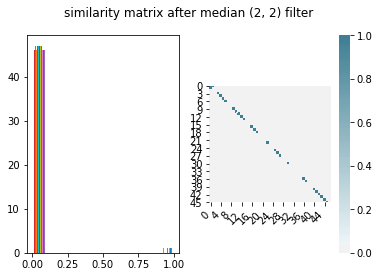

C:\Users\yaniv\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


label 0 has done already cannot evaluate unsequentional segmentation, try other parameters
0.0
|  21       |  0.0      |  1.0      |  60.0     |  134.8    |
                  0
count  77284.000000
mean       0.105841
std        0.150563
min        0.000000
25%        0.042528
50%        0.064933
75%        0.099585
max        1.000000


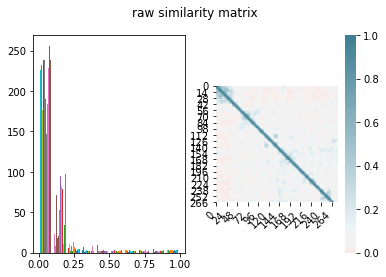

                  0
count  77284.000000
mean       0.105841
std        0.150563
min        0.000000
25%        0.042528
50%        0.064933
75%        0.099585
max        1.000000


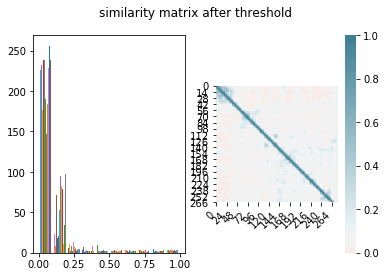

                  0
count  77284.000000
mean       0.110601
std        0.152996
min        0.001293
25%        0.045886
50%        0.068717
75%        0.103820
max        1.000000


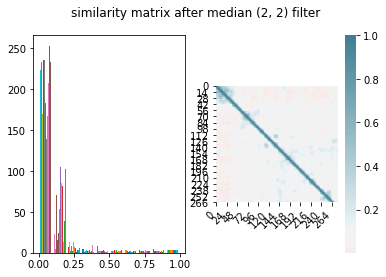

label 13 has done already cannot evaluate unsequentional segmentation, try other parameters
0.0
|  22       |  0.0      |  0.0      |  10.0     |  86.55    |
                  0
count  71824.000000
mean       0.183953
std        0.204467
min        0.002099
25%        0.080527
50%        0.117748
75%        0.172428
max        1.000000


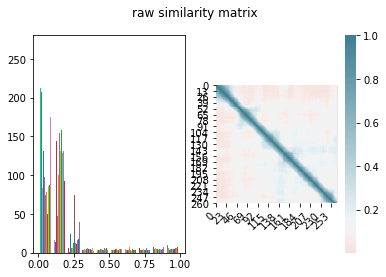

                  0
count  71824.000000
mean       0.002645
std        0.051365
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000


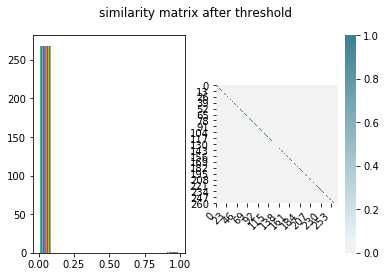

                  0
count  71824.000000
mean       0.001838
std        0.042831
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000


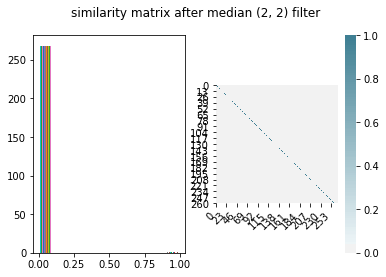

C:\Users\yaniv\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


label 0 has done already cannot evaluate unsequentional segmentation, try other parameters
0.0
|  23       |  0.0      |  1.0      |  10.0     |  191.5    |
                 0
count  6889.000000
mean      0.114364
std       0.158120
min       0.000000
25%       0.047291
50%       0.072185
75%       0.107133
max       1.000000


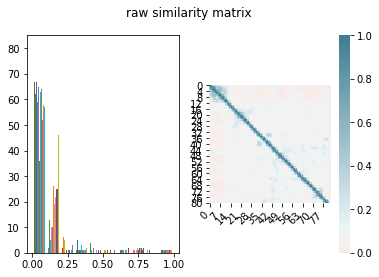

                 0
count  6889.000000
mean      0.009290
std       0.095944
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


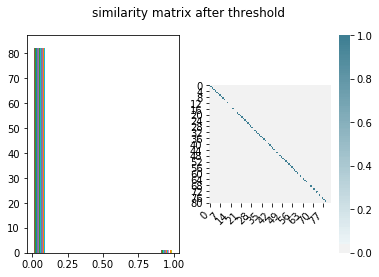

                 0
count  6889.000000
mean      0.007403
std       0.085728
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


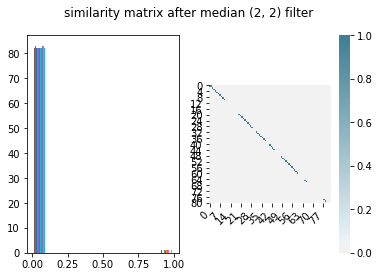

C:\Users\yaniv\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


label 7 has done already cannot evaluate unsequentional segmentation, try other parameters
0.0
|  24       |  0.0      |  1.0      |  34.66    |  95.65    |
                 0
count  2304.000000
mean      0.079588
std       0.143139
min       0.000000
25%       0.027403
50%       0.049190
75%       0.081980
max       1.000000


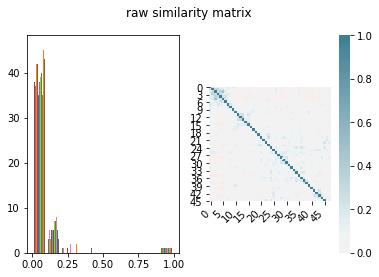

                 0
count  2304.000000
mean      0.017361
std       0.130641
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


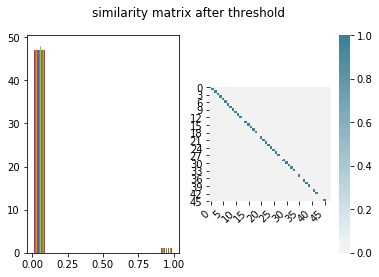

                 0
count  2304.000000
mean      0.015191
std       0.122338
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


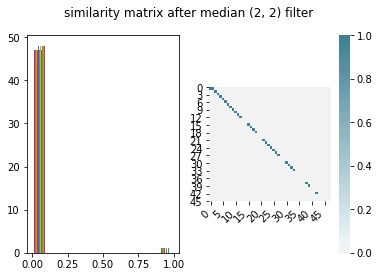

C:\Users\yaniv\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


label 1 has done already cannot evaluate unsequentional segmentation, try other parameters
0.0
|  25       |  0.0      |  1.0      |  60.0     |  51.48    |
                  0
count  80089.000000
mean       0.067055
std        0.114371
min        0.000000
25%        0.020482
50%        0.039480
75%        0.069800
max        1.000000


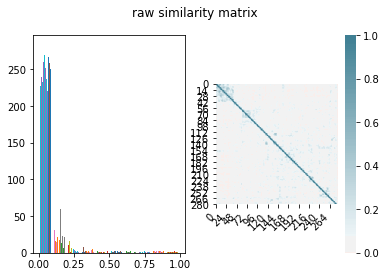

                  0
count  80089.000000
mean       0.032846
std        0.120734
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000


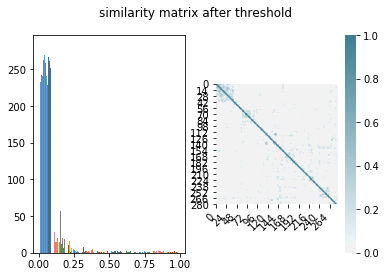

                  0
count  80089.000000
mean       0.036146
std        0.124917
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000


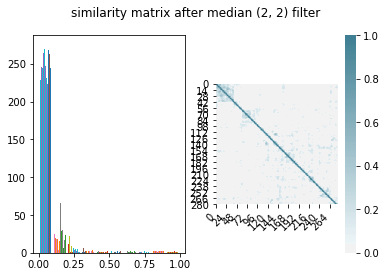

label 15 has done already cannot evaluate unsequentional segmentation, try other parameters
0.0
|  26       |  0.0      |  0.1051   |  10.03    |  44.47    |
                 0
count  9409.000000
mean      0.174893
std       0.199169
min       0.008718
25%       0.075881
50%       0.113123
75%       0.163576
max       1.000000


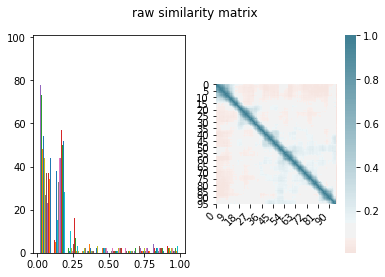

                 0
count  9409.000000
mean      0.008077
std       0.089515
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


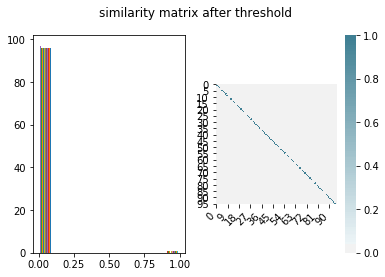

                 0
count  9409.000000
mean      0.006271
std       0.078943
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


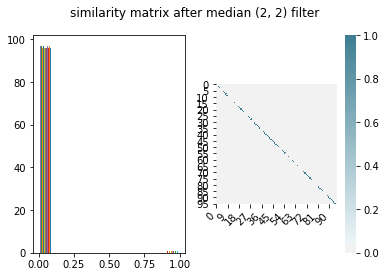

C:\Users\yaniv\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


label 9 has done already cannot evaluate unsequentional segmentation, try other parameters
0.0
|  27       |  0.0      |  1.0      |  28.28    |  178.2    |
                 0
count  3249.000000
mean      0.158002
std       0.190180
min       0.002480
25%       0.068538
50%       0.103223
75%       0.147077
max       1.000000


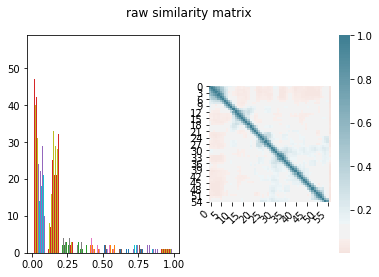

                 0
count  3249.000000
mean      0.158002
std       0.190180
min       0.002480
25%       0.068538
50%       0.103223
75%       0.147077
max       1.000000


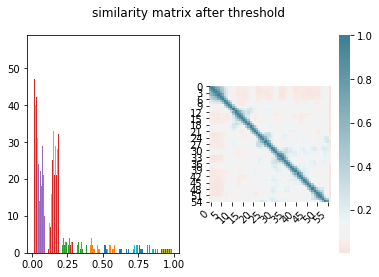

                 0
count  3249.000000
mean      0.171430
std       0.195700
min       0.020013
25%       0.078236
50%       0.112946
75%       0.156767
max       1.000000


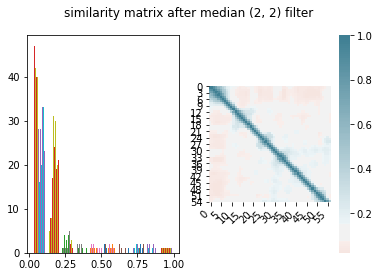

TP: 1 , FP: 17, FN: 16
precision rate : 0.05555555555555555, recall rate : 0.058823529411764705 
0.05555555555555555
|  28       |  0.05556  |  0.0      |  49.85    |  155.9    |


In [72]:
optimizer_MkiUBJcgdUY.maximize(
    init_points = 4,
    n_iter=10
)

In [73]:
for i, res in enumerate(optimizer_MkiUBJcgdUY.res):
    print("Iteration {}: \n\t{}".format(i, res))
print("The max is %s " %(optimizer_MkiUBJcgdUY.max))

Iteration 0: 
	{'target': 0.0, 'params': {'sim_thresh': 0.417022004702574, 'step_size': 74.82920440979423, 'window_size': 20.043462430591056}}
Iteration 1: 
	{'target': 0.0, 'params': {'sim_thresh': 0.30233257263183977, 'step_size': 23.208030173540173, 'window_size': 55.088666012143165}}
Iteration 2: 
	{'target': 0.16666666666666666, 'params': {'sim_thresh': 0.1862602113776709, 'step_size': 41.1004654338743, 'window_size': 170.77164020765457}}
Iteration 3: 
	{'target': 0.0, 'params': {'sim_thresh': 0.538816734003357, 'step_size': 47.72750629629653, 'window_size': 280.3834101507686}}
Iteration 4: 
	{'target': 0.0, 'params': {'sim_thresh': 1.0, 'step_size': 100.0, 'window_size': 177.59151121271952}}
Iteration 5: 
	{'target': 0.1111111111111111, 'params': {'sim_thresh': 0.033365394079127086, 'step_size': 42.84810392245922, 'window_size': 172.63373981820132}}
Iteration 6: 
	{'target': 0.0, 'params': {'sim_thresh': 1.0, 'step_size': 100.0, 'window_size': 400.0}}
Iteration 7: 
	{'target': 0.

In [9]:
optimizer_2mC1uqwEmWQ = BayesianOptimization(
    f=function_to_be_optimized,
    pbounds={'step_size':(10,60),'window_size':(20,200),'sim_thresh':(0,1)},
    verbose=2,
    random_state=1
)

|   iter    |  target   | sim_th... | step_size | window... |
-------------------------------------------------------------
                 0
count  1521.000000
mean      0.269162
std       0.239077
min       0.013754
25%       0.122714
50%       0.172253
75%       0.293086
max       1.000000


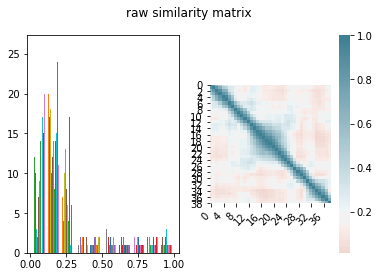

                 0
count  1521.000000
mean      0.091537
std       0.266529
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


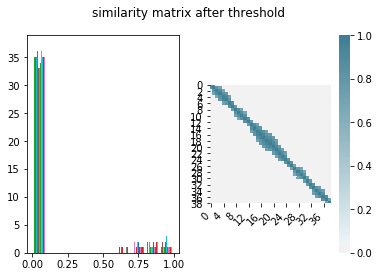

                 0
count  1521.000000
mean      0.100204
std       0.278442
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


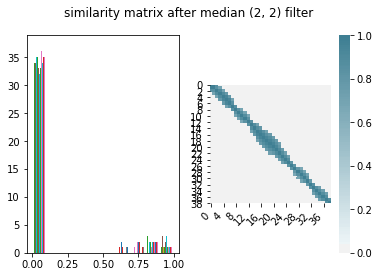

TP: 4 , FP: 11, FN: 10
precision rate : 0.26666666666666666, recall rate : 0.2857142857142857 
0.26666666666666666
|  16       |  0.2667   |  0.6705   |  30.87    |  120.6    |
                 0
count  3481.000000
mean      0.322981
std       0.262231
min       0.004105
25%       0.146491
50%       0.208508
75%       0.423006
max       1.000000


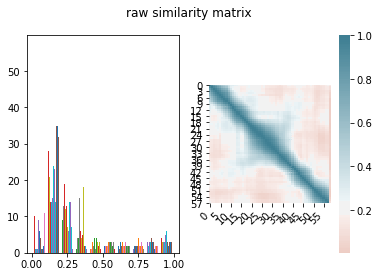

                 0
count  3481.000000
mean      0.301427
std       0.282530
min       0.000000
25%       0.146491
50%       0.208508
75%       0.423006
max       1.000000


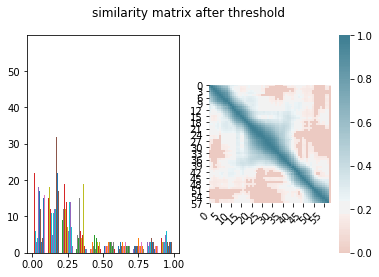

                 0
count  3481.000000
mean      0.321952
std       0.280029
min       0.000000
25%       0.158704
50%       0.218308
75%       0.449426
max       1.000000


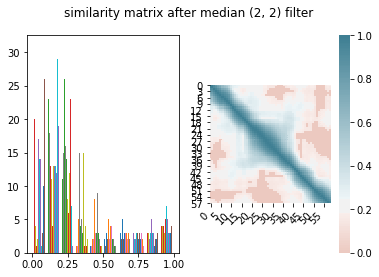

label 2 has done already cannot evaluate unsequentional segmentation, try other parameters
0.0
|  17       |  0.0      |  0.1404   |  19.91    |  164.1    |
                  0
count  15625.000000
mean       0.087497
std        0.138840
min        0.000000
25%        0.013237
50%        0.044136
75%        0.103108
max        1.000000


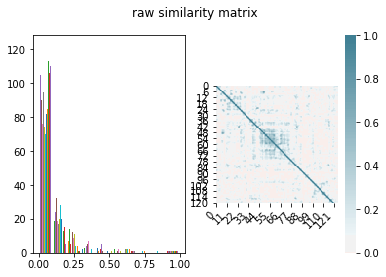

                  0
count  15625.000000
mean       0.087497
std        0.138840
min        0.000000
25%        0.013237
50%        0.044136
75%        0.103108
max        1.000000


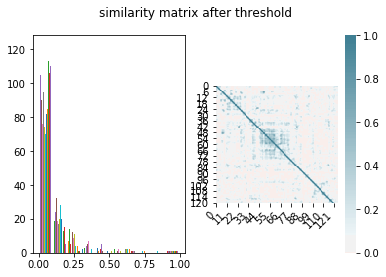

                  0
count  15625.000000
mean       0.101041
std        0.142290
min        0.000000
25%        0.025065
50%        0.057872
75%        0.117323
max        1.000000


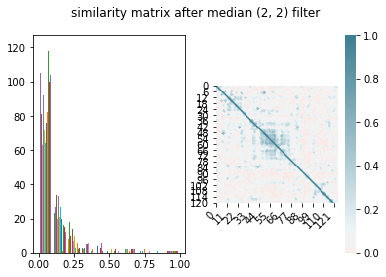

label 14 has done already cannot evaluate unsequentional segmentation, try other parameters
0.0
|  18       |  0.0      |  0.0      |  10.0     |  20.0     |
                  0
count  13924.000000
mean       0.227046
std        0.222803
min        0.000000
25%        0.095331
50%        0.147230
75%        0.236155
max        1.000000


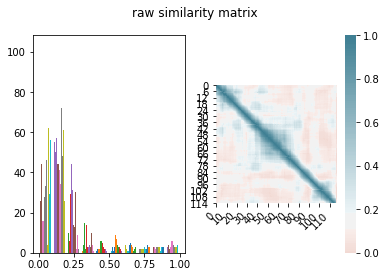

                  0
count  13924.000000
mean       0.006966
std        0.083177
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000


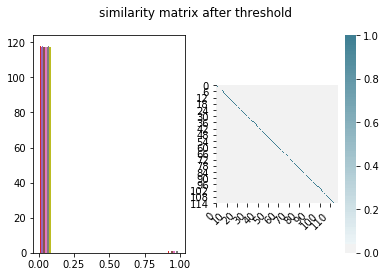

                  0
count  13924.000000
mean       0.005961
std        0.076979
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000


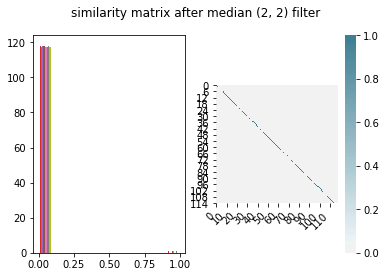

C:\Users\yaniv\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


label 6 has done already cannot evaluate unsequentional segmentation, try other parameters
0.0
|  19       |  0.0      |  1.0      |  10.0     |  92.56    |
                  0
count  12996.000000
mean       0.289402
std        0.249253
min        0.000000
25%        0.130111
50%        0.185334
75%        0.330799
max        1.000000


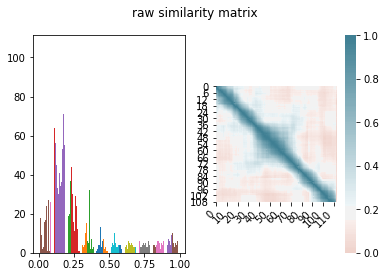

                  0
count  12996.000000
mean       0.289402
std        0.249253
min        0.000000
25%        0.130111
50%        0.185334
75%        0.330799
max        1.000000


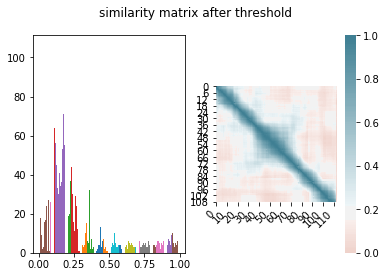

                  0
count  12996.000000
mean       0.299499
std        0.250272
min        0.023240
25%        0.137004
50%        0.191757
75%        0.346855
max        1.000000


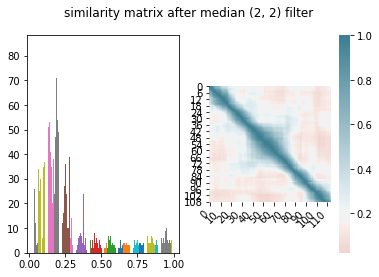

TP: 2 , FP: 13, FN: 12
precision rate : 0.13333333333333333, recall rate : 0.14285714285714285 
0.13333333333333333
|  20       |  0.1333   |  0.0      |  10.0     |  137.6    |
                 0
count  1296.000000
mean      0.164693
std       0.194957
min       0.000000
25%       0.058091
50%       0.101820
75%       0.178118
max       1.000000


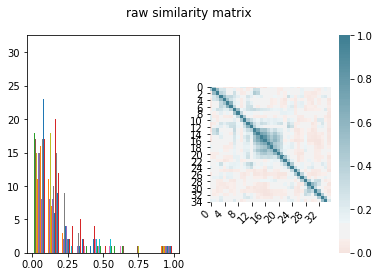

                 0
count  1296.000000
mean      0.164693
std       0.194957
min       0.000000
25%       0.058091
50%       0.101820
75%       0.178118
max       1.000000


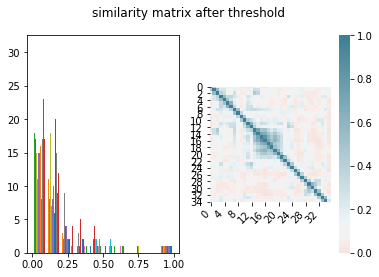

                 0
count  1296.000000
mean      0.188948
std       0.198239
min       0.000000
25%       0.081063
50%       0.121208
75%       0.191589
max       1.000000


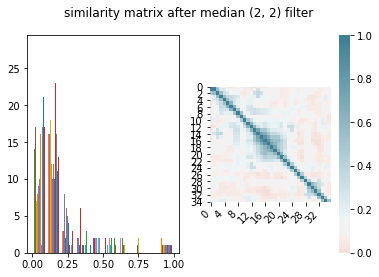

label 4 has done already cannot evaluate unsequentional segmentation, try other parameters
0.0
|  21       |  0.0      |  0.0      |  35.81    |  53.11    |
                 0
count  1156.000000
mean      0.360459
std       0.272684
min       0.016942
25%       0.168956
50%       0.241757
75%       0.523384
max       1.000000


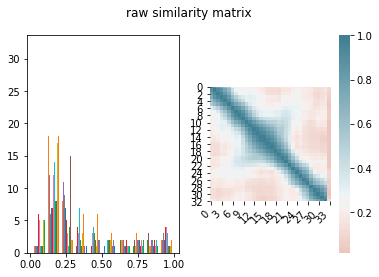

                 0
count  1156.000000
mean      0.360459
std       0.272684
min       0.016942
25%       0.168956
50%       0.241757
75%       0.523384
max       1.000000


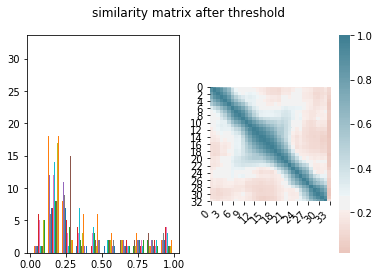

                 0
count  1156.000000
mean      0.386278
std       0.271265
min       0.082753
25%       0.184466
50%       0.260498
75%       0.558042
max       1.000000


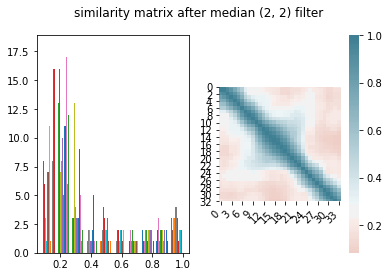

TP: 2 , FP: 13, FN: 12
precision rate : 0.13333333333333333, recall rate : 0.14285714285714285 
0.13333333333333333
|  22       |  0.1333   |  0.0      |  33.72    |  200.0    |


In [12]:
optimizer_2mC1uqwEmWQ.maximize(
    init_points = 2,
    n_iter=5
)

In [13]:
for i, res in enumerate(optimizer_2mC1uqwEmWQ.res):
    print("Iteration {}: \n\t{}".format(i, res))
print("The max is %s " %(optimizer_2mC1uqwEmWQ.max))

Iteration 0: 
	{'target': 0.0, 'params': {'sim_thresh': 0.417022004702574, 'step_size': 46.0162246721079, 'window_size': 20.02058746712208}}
Iteration 1: 
	{'target': 0.0, 'params': {'sim_thresh': 0.30233257263183977, 'step_size': 17.337794540855654, 'window_size': 36.62094705838361}}
Iteration 2: 
	{'target': 0.3333333333333333, 'params': {'sim_thresh': 0.1862602113776709, 'step_size': 27.278036352152387, 'window_size': 91.41814536152059}}
Iteration 3: 
	{'target': 0.0, 'params': {'sim_thresh': 0.538816734003357, 'step_size': 30.95972572016474, 'window_size': 143.33951007141673}}
Iteration 4: 
	{'target': 0.0, 'params': {'sim_thresh': 0.20445224973151743, 'step_size': 53.90587181954727, 'window_size': 24.92976677562671}}
Iteration 5: 
	{'target': 0.0, 'params': {'sim_thresh': 0.5650250402008509, 'step_size': 58.95179729459112, 'window_size': 199.53092132071728}}
Iteration 6: 
	{'target': 0.13333333333333333, 'params': {'sim_thresh': 0.2948475339667701, 'step_size': 29.493717740756246,